# setting up the training data

56
This choice will generate autonomous dynamics
No change  applied to TS or repr data


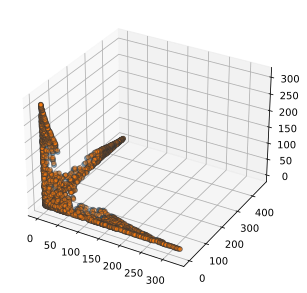

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np
from models.training import create_dataloader, maskedTrainer


# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

# design choices 
chosen_problem = 'repressilator'
data_noise = 0.
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr', 'restricted_TS': 'restrictedTS'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

plotlim = [0, 5]

dataloader, dataloader_viz = create_dataloader(problem, batch_size = 2000, noise = data_noise, 
                                               plotlim = plotlim, random_state = seed, label = 'vector')

# setting up the nODE architecture

In [2]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 1, n_different_weights
bound = 0.
fp = False
cross_entropy = False
turnpike = False

# choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
# another choice is bottleneck, but I don't understand it
# non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
# architecture = 'inside' 'outside'
non_linearity = 'tanh'
architecture = 'inside'
architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1, 'restricted': 2}
# number of optimization runs in which the dataset is used for gradient decent
num_epochs = 50
if problem == 'moons' or problem == 'TS' or problem == "restrictedTS":
    hidden_dim, data_dim = 2, 2 
else:
    hidden_dim, data_dim = 3, 3 
augment_dim = 0

# resets the seed - allows for coherent runs in the gradient descent as well
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
node = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-1) 

# training phase with mask

In [3]:
# explicit mask for the repressilator
mask = torch.Tensor([[0,0.,1.0],[1.0,0,0.],[0,1.0,0]]) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
trainer = maskedTrainer(node, optimizer_node, device, mask, cross_entropy=cross_entropy,
                         bound=bound, verbose = True) 

In [4]:
trainer.train(dataloader, 60)


Iteration 0/25
Loss: 65.919
Masked loss: 1.428

Iteration 10/25
Loss: 45.602
Masked loss: 4.505

Iteration 20/25
Loss: 54.879
Masked loss: 3.694
Epoch 1: 50.544

Iteration 0/25
Loss: 49.915
Masked loss: 2.579

Iteration 10/25
Loss: 41.092
Masked loss: 1.220

Iteration 20/25
Loss: 41.373
Masked loss: 0.264
Epoch 2: 46.009

Iteration 0/25
Loss: 48.494
Masked loss: 0.463

Iteration 10/25
Loss: 42.084
Masked loss: 0.271

Iteration 20/25
Loss: 41.673
Masked loss: 0.187
Epoch 3: 45.113

Iteration 0/25
Loss: 43.360
Masked loss: 0.191

Iteration 10/25
Loss: 45.664
Masked loss: 0.059

Iteration 20/25
Loss: 51.900
Masked loss: 0.197
Epoch 4: 44.845

Iteration 0/25
Loss: 40.134
Masked loss: 0.165

Iteration 10/25
Loss: 42.778
Masked loss: 0.197

Iteration 20/25
Loss: 47.787
Masked loss: 0.136
Epoch 5: 44.810

Iteration 0/25
Loss: 40.432
Masked loss: 0.142

Iteration 10/25
Loss: 51.898
Masked loss: 0.109

Iteration 20/25
Loss: 50.607
Masked loss: 0.110
Epoch 6: 44.729

Iteration 0/25
Loss: 50.712

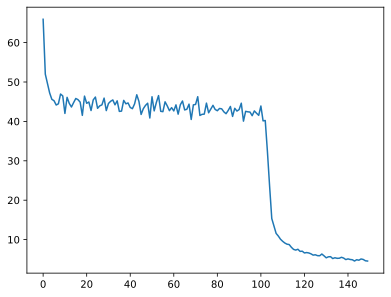

In [5]:
plt.plot(trainer.histories['loss_history'])

In [6]:
trainer.model.flow.dynamics.fc2_time[0].weight 

Parameter containing:
tensor([[ 1.4405e-01,  1.7639e-02, -1.6008e+01],
        [-2.1304e+01,  3.1287e-03, -3.4825e-02],
        [-3.2368e-02, -1.4837e+01,  1.6732e-01]], requires_grad=True)

In [7]:
trainer.model.flow.dynamics.fc2_time[0].bias

Parameter containing:
tensor([14.7150, 19.8533, 13.5443], requires_grad=True)

In [8]:
mask

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])

In [9]:
(trainer.model.flow.dynamics.fc2_time[0].weight * (1 - trainer.mask)).norm(1)

tensor(0.3993, grad_fn=<LinalgVectorNormBackward0>)

In [10]:
node.forward(torch.Tensor([1.,2.,3.]))[0].detach()

tensor([ 0.0811, 12.4838,  1.7960])

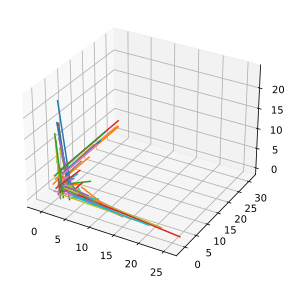

In [11]:
from torch.distributions.uniform import Uniform

low, high = plotlim  # range of uniform distribution
size = 70
shape = size, 3
X = np.array(Uniform(low, high).sample(shape) )
ax = plt.figure().add_subplot(projection='3d')

for x0 in X:
    x1 = node.forward(torch.Tensor(x0))[0].detach()
    x = np.array([x0[0], x1[0]])
    y = np.array([x0[1], x1[1]])
    z = np.array([x0[2], x1[2]])
    ax.plot(x, y, z)

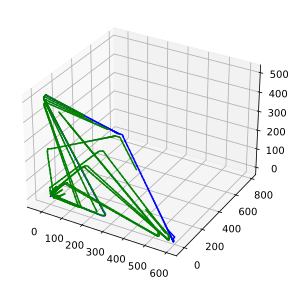

In [12]:
ax = plt.figure().add_subplot(projection='3d')
start = torch.Tensor([1,2,3.])
for i in range(200):
    traj = node.flow.trajectory(start, 10)
    ax.plot(traj.detach().numpy()[:,0],traj.detach().numpy()[:,1],traj.detach().numpy()[:,2],color='b')
    start = traj[-1,:]
for j in range(10):
    shape = 1,3
    start = Uniform(0,60).sample(shape)[0]
    for i in range(80):
        traj = node.flow.trajectory(start, 10)
        ax.plot(traj.detach().numpy()[:,0],traj.detach().numpy()[:,1],traj.detach().numpy()[:,2],color='g')
        start = traj[-1,:]
    

# original system

In [13]:
def repressilator(xyz, t):
    x, y, z = xyz[0], xyz[1], xyz[2]
    n = 5
    gamma, lx, ly, lz, deltax, deltay, deltaz, thetax, thetay, thetaz = 0.05, 0.01, 0.02, 0.03, 30.1, 30.2, 20.7, 1, 1.1, 1.2
    x_dot = - gamma * x + lx + deltax * thetax ** n / (thetax ** n + z ** n)
    y_dot = - gamma * y + ly + deltay * thetay ** n / (thetay ** n + x ** n)
    z_dot = - gamma * z + lz + deltaz * thetaz ** n / (thetaz ** n + y ** n)
    return np.array([x_dot, y_dot, z_dot])

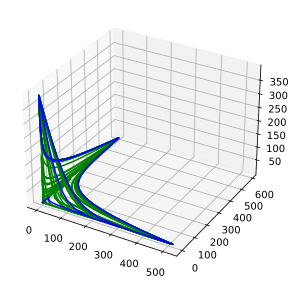

In [14]:
import scipy


iters = 20
size = [iters, 3]  # dimension of the pytorch tensor to be generated
low, high = plotlim  # range of uniform distribution

X = np.array(torch.distributions.uniform.Uniform(low, high).sample(size))

deltat = .5
Y = np.array([scipy.integrate.odeint(repressilator,
                            X[i, :], np.linspace(0,80*4,100))
                            for i in range(iters)])

ax = plt.figure().add_subplot(projection='3d')
for i in range(iters):
    ax.plot(Y[i,:,0],Y[i,:,1],Y[i,:,2],color='g')

Y = scipy.integrate.odeint(repressilator,
                            np.array([1,2,3.]), np.linspace(0,200*4,300))
                            
ax.plot(Y[:,0],Y[:,1],Y[:,2],color='b')

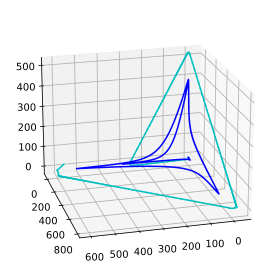

In [26]:
ax = plt.figure().add_subplot(projection='3d')
start = torch.Tensor([1,2,3.])
for i in range(200):
    traj = node.flow.trajectory(start, 20)
    ax.plot(traj.detach().numpy()[:,0],traj.detach().numpy()[:,1],traj.detach().numpy()[:,2],color='c')
    start = traj[-1,:]
Y = scipy.integrate.odeint(repressilator,
                            np.array([1,2,3.]), np.linspace(0,200*4,300))
                            
ax.plot(Y[:,0],Y[:,1],Y[:,2],color='b')
azm=ax.azim

ax.view_init(elev=20, azim=-1.25*azm)

In [37]:
torch.log(torch.abs(node.flow.dynamics.fc2_time[0].weight))

tensor([[-1.9376, -4.0377,  2.7731],
        [ 3.0589, -5.7671, -3.3574],
        [-3.4306,  2.6971, -1.7879]], grad_fn=<LogBackward0>)

In [33]:
mask

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])